## Loading Packages

In [1]:
import pandas as pd
import nltk as nltk

from google.cloud import storage
import io

In [2]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [4]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading Data

In [5]:
#Saving results of massage volume
bucket_write = 'msca-bdp-students-bucket/shared_data/haoruw'

In [6]:
path = 'gs://msca-bdp-tweets/final_project'
data = spark.read.json(path)

In [7]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## Discard Irrelevant Rows

In [8]:
df_text_covid = data.filter(lower(data.text).contains("covid"))

In [19]:
df_text_covid.count()

14973841

## EDA

In [9]:
org_gov = ['gov', 'congress', 'representative', 'presiden']
org_health = ['health', 'hospital']
org_news = ['news', 'press', 'post', 'journal']
org_social_media = ['youtuber', 'streamer', 'tik tok', 'influencer']
org_celebrity = ['singer', 'musician', 'actor', 'actress', 'movie', 'producer', 'rapper']

In [10]:
org_dict = {'government': org_gov, 
            'health': org_health,
            'news' : org_news,
            'social_media' : org_social_media,
            'celebrity' : org_celebrity
           }

#### Sublsletting Dataset

In [11]:
df_user_time = df_text_covid.select('user.id', 'user.description', 'created_at', 'text', 'place')

In [12]:
df_user_time = df_user_time.\
withColumnRenamed('created_at', 'time')


In [34]:
df_user_time.show(5)

+-------------------+--------------------+--------------------+--------------------+-----+
|                 id|         description|                time|                text|place|
+-------------------+--------------------+--------------------+--------------------+-----+
|          586248544|Mostly skating ba...|Sat Oct 30 02:52:...|@GarrAarghHrumph ...| null|
|1109641163890319360| Soldier of the Lion|Sat Oct 30 02:52:...|RT @Denise_Old_La...| null|
|          214105439|Often tweets abou...|Sat Oct 30 02:52:...|@pahpcorn @Lisa_T...| null|
|          954159751|Futures trader. I...|Sat Oct 30 02:52:...|@polan13 @mark_do...| null|
|         4879591625|                null|Sat Oct 30 02:52:...|RT @LegendaryEner...| null|
+-------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [13]:
df_user_time.printSchema()

root
 |-- id: long (nullable = true)
 |-- description: string (nullable = true)
 |-- time: string (nullable = true)
 |-- text: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- full_name: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |    |-- url: string (nullable = true)



### Converting DateTime

In [14]:
from datetime import datetime
import pytz

In [15]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [16]:
df_user_time = df_user_time.\
withColumn('timestamp', from_unixtime(
    unix_timestamp(col("time"),
                        "EEE MMM dd HH:mm:ss ZZZZ yyyy"))).\
withColumn('day', split(col('time'), " \s*").alias("time_split"))


In [17]:
df_user_time.show(5)

+-------------------+--------------------+--------------------+--------------------+-----+-------------------+--------------------+
|                 id|         description|                time|                text|place|          timestamp|                 day|
+-------------------+--------------------+--------------------+--------------------+-----+-------------------+--------------------+
|          586248544|Mostly skating ba...|Sat Oct 30 02:52:...|@GarrAarghHrumph ...| null|2021-10-30 02:52:21|[Sat, Oct, 30, 02...|
|1109641163890319360| Soldier of the Lion|Sat Oct 30 02:52:...|RT @Denise_Old_La...| null|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|
|          214105439|Often tweets abou...|Sat Oct 30 02:52:...|@pahpcorn @Lisa_T...| null|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|
|          954159751|Futures trader. I...|Sat Oct 30 02:52:...|@polan13 @mark_do...| null|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|
|         4879591625|                null|Sat Oct 30 02:52:...|RT @Legendary

In [18]:
df_user_time = df_user_time.withColumn("organization", lit('other'))

In [19]:
for key, value in org_dict.items():
    for k in value:
        df_user_time = df_user_time.\
        withColumn("organization", when(lower(df_user_time.description).contains(k), key).\
                   otherwise(df_user_time.organization))


In [20]:
df_user_time = df_user_time.drop('description')

### Build another dictionary for sorting texts

In [21]:
text_vaccine = ['booster', 'shot', 'pfizer', 'moderna', 'cvs', 'walgreens', 'vaccine']
text_health = ['hospital', 'doctor', 'nurse', 'clinic']
text_public = ['speaker', 'president', 'reporter', 'interview', 'news']
text_life_related = ['work', 'wash', 'hand', 'stay', 'cold']

In [22]:
text_dict = {'vaccine': text_vaccine, 
            'health': text_health,
            'public' : text_public,
            'life_related' : text_life_related
           }

In [23]:
df_user_time = df_user_time.withColumn("text_theme", lit('other'))

In [24]:
for key, value in text_dict.items():
    for k in value:
        df_user_time = df_user_time.\
        withColumn("text_theme", when(lower(df_user_time.text).contains(k), key).\
                   otherwise(df_user_time.text_theme))


In [25]:
df_user_time = df_user_time.drop('text')

In [26]:
df_user_time.show(5)

+-------------------+--------------------+-----+-------------------+--------------------+------------+----------+
|                 id|                time|place|          timestamp|                 day|organization|text_theme|
+-------------------+--------------------+-----+-------------------+--------------------+------------+----------+
|          586248544|Sat Oct 30 02:52:...| null|2021-10-30 02:52:21|[Sat, Oct, 30, 02...|       other|   vaccine|
|1109641163890319360|Sat Oct 30 02:52:...| null|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|       other|     other|
|          214105439|Sat Oct 30 02:52:...| null|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|        news|     other|
|          954159751|Sat Oct 30 02:52:...| null|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|       other|   vaccine|
|         4879591625|Sat Oct 30 02:52:...| null|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|       other|     other|
+-------------------+--------------------+-----+-------------------+--------------------

In [27]:
df_user_time = df_user_time.\
withColumn('date', date_format('timestamp', "MM-dd-yyyy")).\
withColumn('hour', hour('timestamp')).\
withColumn('weekday', element_at(col('day'), 1))

In [36]:
df_user_time_save = df_user_time.drop('day', 'time')

In [37]:
df_user_time_save.show(5)

+-------------------+-----+-------------------+------------+----------+----------+----+-------+
|                 id|place|          timestamp|organization|text_theme|      date|hour|weekday|
+-------------------+-----+-------------------+------------+----------+----------+----+-------+
|          586248544| null|2021-10-30 02:52:21|       other|   vaccine|10-30-2021|   2|    Sat|
|1109641163890319360| null|2021-10-30 02:52:22|       other|     other|10-30-2021|   2|    Sat|
|          214105439| null|2021-10-30 02:52:22|        news|     other|10-30-2021|   2|    Sat|
|          954159751| null|2021-10-30 02:52:22|       other|   vaccine|10-30-2021|   2|    Sat|
|         4879591625| null|2021-10-30 02:52:22|       other|     other|10-30-2021|   2|    Sat|
+-------------------+-----+-------------------+------------+----------+----------+----+-------+
only showing top 5 rows



In [55]:
df_user_time_save.write.format('json').\
option("header", "true").\
mode('overwrite').\
save('gs://' + bucket_write + '/df_user_time')

KeyboardInterrupt: 

In [ ]:
df = spark.read.json('gs://' + bucket_write + '/df_user_time')

In [31]:
df_user_time.show(5)

+-------------------+--------------------+----------+----+-------+
|          timestamp|                 day|      date|hour|weekday|
+-------------------+--------------------+----------+----+-------+
|2021-10-30 02:52:21|[Sat, Oct, 30, 02...|10-30-2021|   2|    Sat|
|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|10-30-2021|   2|    Sat|
|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|10-30-2021|   2|    Sat|
|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|10-30-2021|   2|    Sat|
|2021-10-30 02:52:22|[Sat, Oct, 30, 02...|10-30-2021|   2|    Sat|
+-------------------+--------------------+----------+----+-------+
only showing top 5 rows



In [20]:
df_user_time.count()

14973841

In [32]:
df_user_time_save.describe()

summary,id,organization,text_theme,date,hour,weekday
count,14973841,14973841,14973841,14973841,14973841,14973841
mean,5.452431257649351...,null,null,null,12.684098355258348,null
stddev,6.030971783515086...,null,null,null,6.8611826259767055,null
min,21,celebrity,health,10-15-2021,0,Fri
max,1459017425274368000,social_media,vaccine,11-12-2021,23,Wed


In [33]:
df_user_time_save.printSchema()

root
 |-- id: long (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- full_name: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- organization: string (nullable = false)
 |-- text_theme: string (nullable = false)
 |-- date: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday: string (nullable = true)



In [98]:
def getDate(x):
    if x is not None:
        return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

## UDF declaration
date_fn = udf(getDate, StringType())

## Converting datatype in spark dataframe
df = df_date.withColumn("date", to_utc_timestamp(date_fn("created_at"),"UTC")) 

## Geolocation

In [38]:
df_place = df_user_time_save.filter('place IS NOT NULL')

In [39]:
df_place.show(5)

+------------------+--------------------+-------------------+------------+----------+----------+----+-------+
|                id|               place|          timestamp|organization|text_theme|      date|hour|weekday|
+------------------+--------------------+-------------------+------------+----------+----------+----+-------+
|947746683529469952|[[[[[77.302126, 2...|2021-10-30 02:52:52|      health|     other|10-30-2021|   2|    Sat|
|         114377510|[[[[[-79.639319, ...|2021-10-30 02:53:31|       other|     other|10-30-2021|   2|    Sat|
|         411216357|[[[[[-117.282538,...|2021-10-30 02:54:06|       other|   vaccine|10-30-2021|   2|    Sat|
|        2397254618|[[[[[-64.336105, ...|2021-11-12 03:08:08|       other|   vaccine|11-12-2021|   3|    Fri|
|         936078120|[[[[[-79.639319, ...|2021-10-21 15:07:38|       other|    public|10-21-2021|  15|    Thu|
+------------------+--------------------+-------------------+------------+----------+----------+----+-------+
only showi

In [21]:
df_place.select('place').show(5, truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|place                                                                                                                                                                                                                                                                   |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[[[[77.302126, 28.443981], [77.302126, 28.647131], [77.695326, 28.647131], [77.695326, 28.443981]]], Polygon], India, IN, Noida, India, 2e6064382c71b343, Noida, city, https://api.twitter.com/1.1/ge

In [46]:
df_map = df_place.select('id', 'place.country', 'place.country_code', 'timestamp').\
withColumn('month', month('timestamp'))

In [43]:
df_map.show(5)

+------------------+-------------+------------+-------------------+-----+
|                id|      country|country_code|          timestamp|month|
+------------------+-------------+------------+-------------------+-----+
|947746683529469952|        India|          IN|2021-10-30 02:52:52|   10|
|         114377510|       Canada|          CA|2021-10-30 02:53:31|   10|
|         411216357|United States|          US|2021-10-30 02:54:06|   10|
|        2397254618|       Canada|          CA|2021-11-12 03:08:08|   11|
|         936078120|       Canada|          CA|2021-10-21 15:07:38|   10|
+------------------+-------------+------------+-------------------+-----+
only showing top 5 rows



In [47]:
df_map_10 = df_map.filter('month == 10')

In [48]:
df_map_11 = df_map.filter('month == 11')

In [51]:
df_map_10 = df_map_10.dropDuplicates((['id'])).select('id', 'country', 'country_code')

In [50]:
df_map_11 = df_map_11.dropDuplicates((['id'])).select('id', 'country', 'country_code')

In [53]:
df_map_10.show(5)

+--------+--------------+------------+
|      id|       country|country_code|
+--------+--------------+------------+
|  781154|United Kingdom|          GB|
|15977967| United States|          US|
|17414054| United States|          US|
|17637601| United States|          US|
|18503412|     Gibraltar|          GI|
+--------+--------------+------------+
only showing top 5 rows



In [54]:
df_country_10 = df_map_10.groupBy('country_code').agg(count('*').alias('count')).orderBy('count',ascending = False)

In [61]:
df_country_11 = df_map_11.groupBy('country_code').agg(count('*').alias('count')).orderBy('count',ascending = False)

In [57]:
df_country_10.show()

+------------+-----+
|country_code|count|
+------------+-----+
|          US|12974|
|          GB| 5082|
|          IN| 1375|
|          CA| 1329|
|          AU|  928|
|          IE|  482|
|          ZA|  477|
|          NZ|  295|
|          PH|  181|
|          ES|  164|
|          UG|  139|
|          KE|  134|
|          FR|  117|
|          MY|  116|
|          PK|  105|
|          IT|   93|
|          DE|   91|
|          MX|   86|
|          NL|   78|
|          BR|   72|
+------------+-----+
only showing top 20 rows



In [58]:
df_country_10.count()

170

In [59]:
pip install pycountry

     |████████████████████████████████| 10.1 MB 5.3 MB/s eta 0:00:01
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=cec7d66db39a6ae726e69779b77d61062362c40a5154ce1868ebce4bee0bc4d6
  Stored in directory: /root/.cache/pip/wheels/09/eb/0d/4ee773c6a4aadc2a43cb5c1d07f268f13c4cdc0eec88e7c1ef
Successfully built pycountry
Note: you may need to restart the kernel to use updated packages.


In [60]:
import pycountry

In [62]:
pd_df_country_10 = df_country_10.limit(10000).toPandas()

In [63]:
pd_df_country_11 = df_country_11.limit(10000).toPandas()

In [84]:
pd_df_country_10.head(n=10)

,count,iso_a3
0,12971,USA
1,5079,GBR
2,1376,IND
3,1330,CAN
4,928,AUS
5,484,IRL
6,478,ZAF
7,295,NZL
8,181,PHL
9,161,ESP


In [85]:
pd_df_country_11.head(n=10)

,count,iso_a3
0,10297,USA
1,3138,GBR
2,922,CAN
3,708,IND
4,544,AUS
5,356,IRL
6,320,ZAF
7,201,NZL
8,131,PHL
9,96,MYS


In [65]:
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
def country_flag(x):
    if (x in list_alpha_2):
        return pycountry.countries.get(alpha_2=x).alpha_3
    else:
        return 'null'

In [66]:
pd_df_country_10['iso_a3'] = pd_df_country_10['country_code'].apply(lambda x: country_flag(x))


In [67]:
pd_df_country_11['iso_a3'] = pd_df_country_11['country_code'].apply(lambda x: country_flag(x))


In [69]:
import geopandas

In [70]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [71]:
pd_world = world[['name', 'iso_a3', 'geometry']]

<AxesSubplot:>

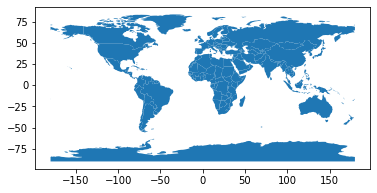

In [258]:
pd_world.plot()

In [72]:
pd_df_country_10 = pd_df_country_10[['count', 'iso_a3']]

In [73]:
pd_df_country_11 = pd_df_country_11[['count', 'iso_a3']]

In [74]:
# then merge with our data 
merge_10=pd.merge( pd_world, pd_df_country_10, on='iso_a3')

In [75]:
merge_11=pd.merge( pd_world, pd_df_country_11, on='iso_a3')

In [77]:
from geopandas import GeoDataFrame

In [78]:
merged_10 = GeoDataFrame(merge_10)

In [79]:
merged_11 = GeoDataFrame(merge_11)

In [80]:
merged_10.count()

name        135
iso_a3      135
geometry    135
count       135
dtype: int64

<AxesSubplot:>

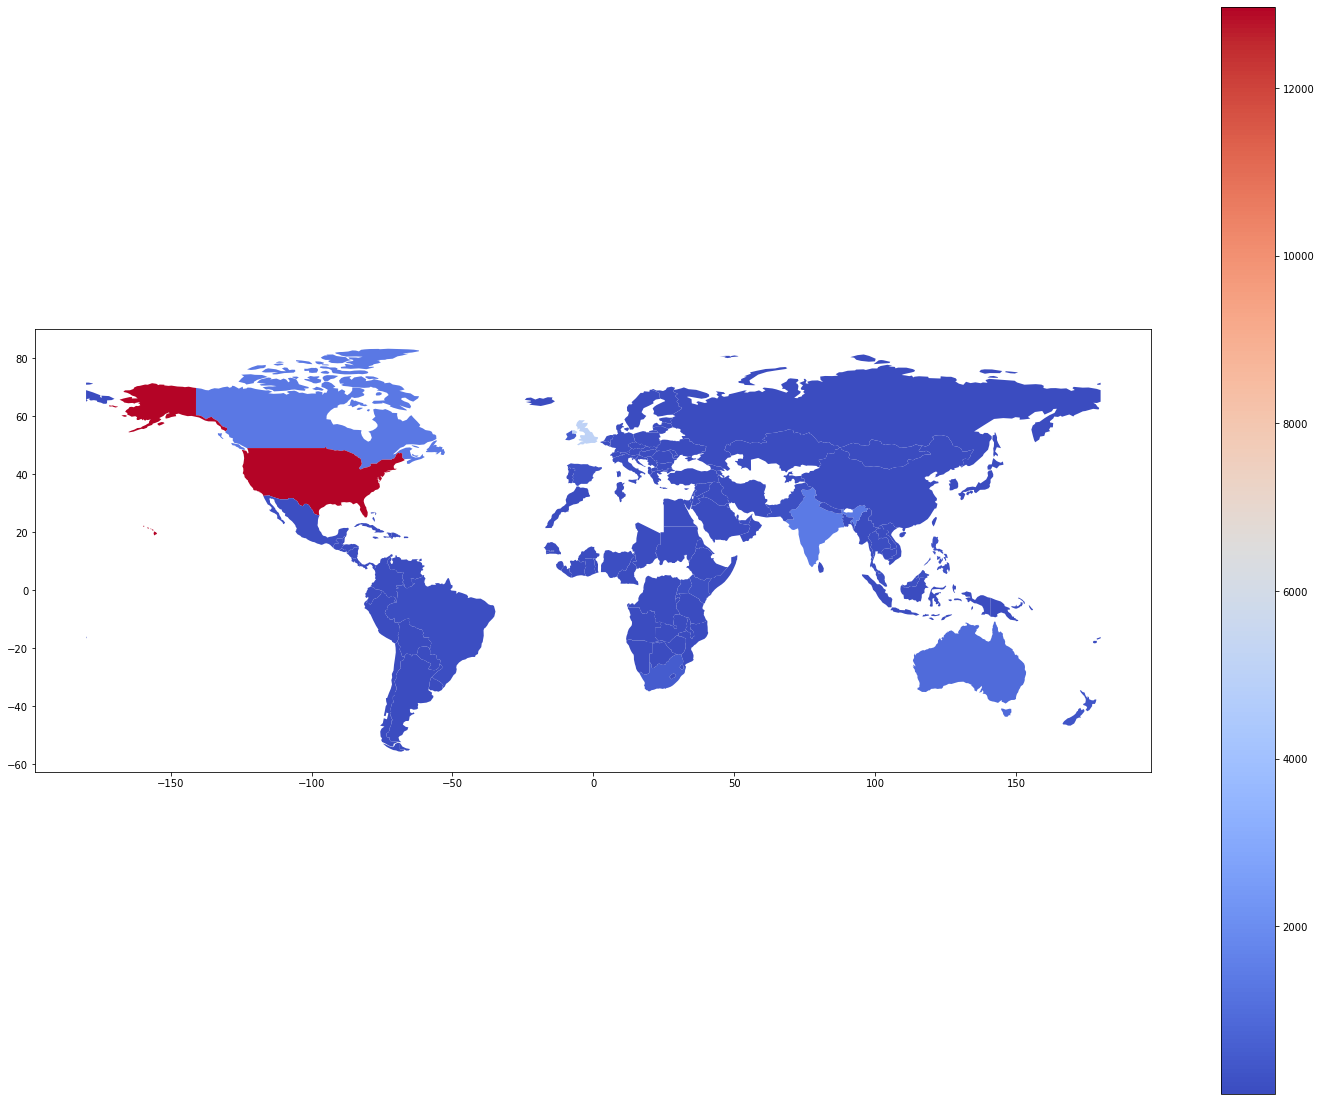

In [82]:
merged_10.plot(column='count',legend = True, figsize=(25, 20), cmap='coolwarm')


<AxesSubplot:>

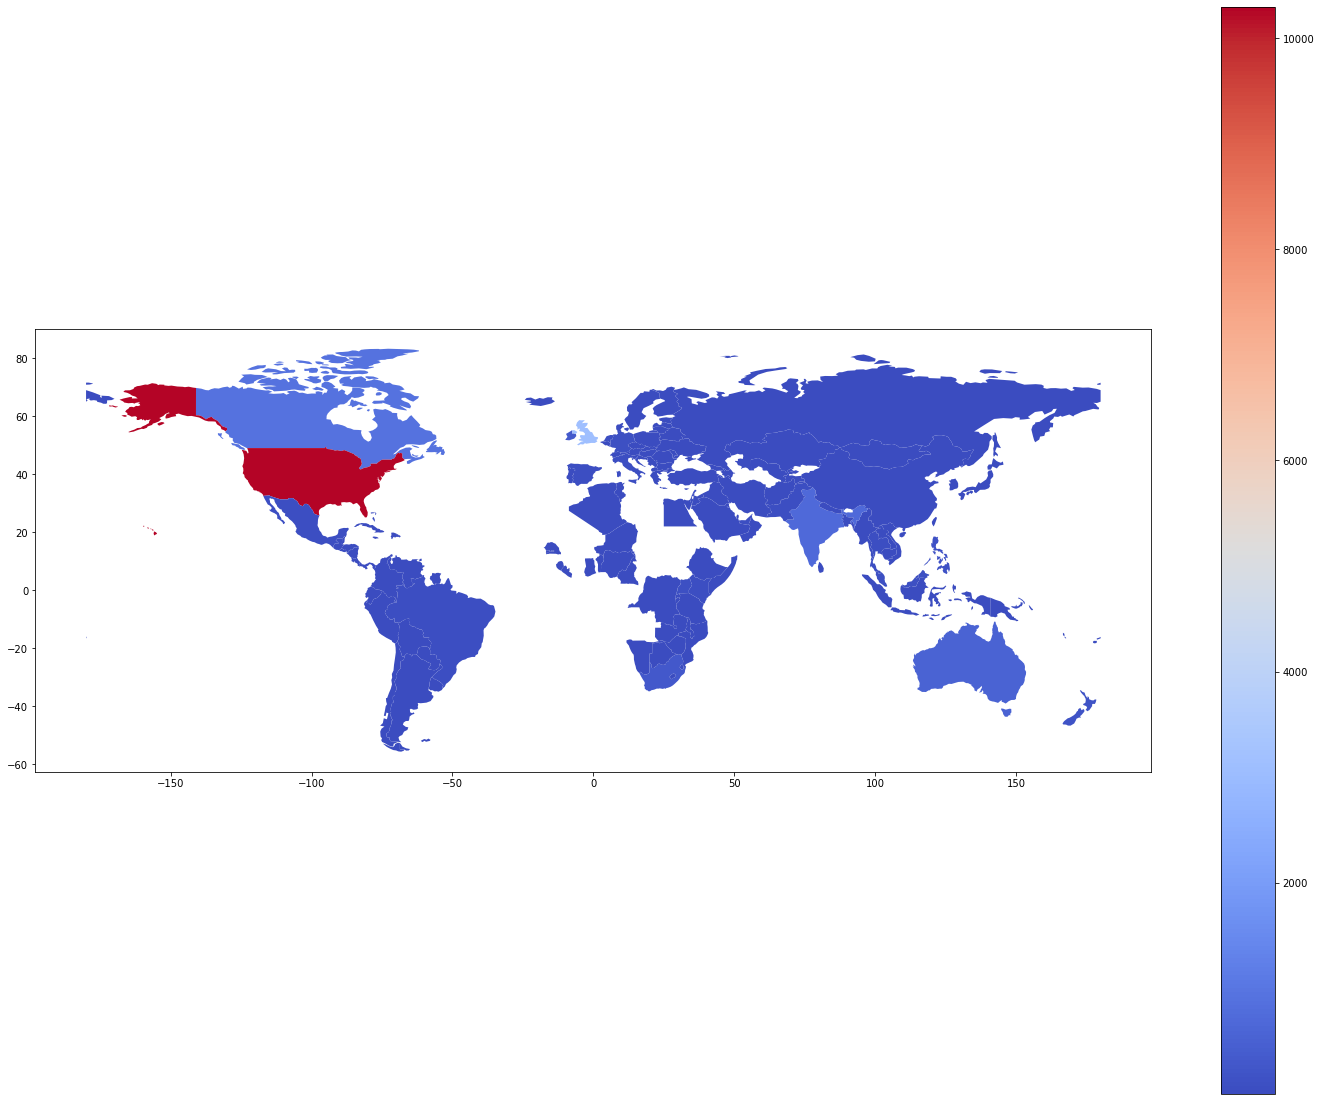

In [83]:
merged_11.plot(column='count',legend = True, figsize=(25, 20), cmap='coolwarm')


### Geolocation

In [34]:
df_text_covid.filter('geo IS NOT NULL').count()

1681

In [31]:
df_user_time.filter('user.geo_enabled == true').filter('user.location IS NOT NULL').select('user.location')

+--------------------+
|            location|
+--------------------+
|           Singapore|
|Michoacán y Ingle...|
|Auckland, New Zea...|
|       7dream/19/she|
|         Palmyra, NY|
|       United States|
|        Portland, ME|
|            Aotearoa|
|             ⊹˚┊✿┊˚⊹|
|     New Orleans, LA|
+--------------------+
only showing top 10 rows



In [37]:
df_geo = df_user_time.filter('user.geo_enabled == true').filter('user.location IS NOT NULL').\
select('user.id', 'user.location', 'time')

In [38]:
df_geo.show(5)

+------------------+--------------------+-------------------+
|                id|            location|               time|
+------------------+--------------------+-------------------+
|         214105439|           Singapore|2021-10-30 02:52:22|
|         104671559|Michoacán y Ingle...|2021-10-30 02:52:23|
|        2454667705|Auckland, New Zea...|2021-10-30 02:52:24|
|883801533560836096|       7dream/19/she|2021-10-30 02:52:24|
|        2712364604|         Palmyra, NY|2021-10-30 02:52:24|
+------------------+--------------------+-------------------+
only showing top 5 rows



In [49]:
df_geo_id = df_geo.dropDuplicates((['id'])).select('id', 'location', 'time')


In [ ]:
df_geo_id.show(5)

+------+--------------------+-------------------+
|    id|            location|               time|
+------+--------------------+-------------------+
|   964|     $$NO_BUILDING$$|2021-11-05 04:50:02|
|747203|iPhone: 51.585331...|2021-10-17 14:28:22|
|781154|       Cambridge, UK|2021-11-01 10:55:08|
|806000|             Dundalk|2021-10-18 23:28:26|
|814261|richmond, musquea...|2021-11-06 20:30:39|
+------+--------------------+-------------------+
only showing top 5 rows



In [51]:
df_geo_id.count()

916833

In [52]:
df_geo_id = df_geo_id.select('id', 'location')

### Saving Data

In [53]:
#Saving results of massage volume
bucket_write = 'msca-bdp-students-bucket/shared_data/haoruw'

In [54]:
df_geo_id.write.format("com.databricks.spark.csv").\
option("header", "true").\
mode('overwrite').\
save('gs://' + bucket_write + '/df_geo_id')

In [7]:
df_geo = spark.read.csv('gs://' + bucket_write + '/df_geo_id', header='true', inferSchema='true')



In [8]:
df_geo.show(5)

+-----+--------------------+
|   id|            location|
+-----+--------------------+
| 7259|           Vancouver|
|12337|         Chicago, IL|
|39093|iPhone: 52.892892...|
|39783|          Verona, WI|
|44333|Sheffield, Aotear...|
+-----+--------------------+
only showing top 5 rows



In [65]:
!pip install geonamescache

     |████████████████████████████████| 2.6 MB 2.2 MB/s eta 0:00:01


In [66]:
import geonamescache

In [75]:
df_geo.sample(0.2)

id,location
332163,"Healdsburg, CA"
2459711,Rapa Nui
3071601,A ravine somewher...
5291602,"Pittsburgh, PA"
8259142,Allston Rock City
9544582,Chicago
10097522,"England, United K..."
11759072,Hamburg
11763832,"Palo Alto, CA"
14089909,Earth


In [9]:
df_geo_general = df_geo.select(col("id"), split(col("location"), ",\s*").alias("location"))


In [10]:
df_geo_general.show(5)

+-----+--------------------+
|   id|            location|
+-----+--------------------+
| 7259|         [Vancouver]|
|12337|       [Chicago, IL]|
|39093|[iPhone: 52.89289...|
|39783|        [Verona, WI]|
|44333|[Sheffield, Aotea...|
+-----+--------------------+
only showing top 5 rows



In [11]:
df_geo_general = df_geo_general.\
withColumn('general_location', lower(element_at(col('location'), -1)))

In [12]:
df_geo_general.show(5)

+-----+--------------------+----------------+
|   id|            location|general_location|
+-----+--------------------+----------------+
| 7259|         [Vancouver]|       vancouver|
|12337|       [Chicago, IL]|              il|
|39093|[iPhone: 52.89289...|       -1.431639|
|39783|        [Verona, WI]|              wi|
|44333|[Sheffield, Aotea...|     aotearoa nz|
+-----+--------------------+----------------+
only showing top 5 rows



In [71]:
df_geo_processed = df_geo.withColumn("location",
   lower(concat_ws(",",col("location"))))

In [76]:
gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
# print countries dictionary
print(countries)

{'AD': {'geonameid': 3041565, 'name': 'Andorra', 'iso': 'AD', 'iso3': 'AND', 'isonumeric': 20, 'fips': 'AN', 'continentcode': 'EU', 'capital': 'Andorra la Vella', 'areakm2': 468, 'population': 84000, 'tld': '.ad', 'currencycode': 'EUR', 'currencyname': 'Euro', 'phone': '376', 'postalcoderegex': '^(?:AD)*(\\d{3})$', 'languages': 'ca', 'neighbours': 'ES,FR'}, 'AE': {'geonameid': 290557, 'name': 'United Arab Emirates', 'iso': 'AE', 'iso3': 'ARE', 'isonumeric': 784, 'fips': 'AE', 'continentcode': 'AS', 'capital': 'Abu Dhabi', 'areakm2': 82880, 'population': 4975593, 'tld': '.ae', 'currencycode': 'AED', 'currencyname': 'Dirham', 'phone': '971', 'postalcoderegex': '', 'languages': 'ar-AE,fa,en,hi,ur', 'neighbours': 'SA,OM'}, 'AF': {'geonameid': 1149361, 'name': 'Afghanistan', 'iso': 'AF', 'iso3': 'AFG', 'isonumeric': 4, 'fips': 'AF', 'continentcode': 'AS', 'capital': 'Kabul', 'areakm2': 647500, 'population': 29121286, 'tld': '.af', 'currencycode': 'AFN', 'currencyname': 'Afghani', 'phone': '

In [82]:
def get_loc (locs):
    for loc in locs:
        loc = loc.lower()
        loctitle = loc.title()
        locupper = loc.upper()
        if loc in countries_by_names:
            return loc
        elif loc in us_states:
            return loc
        elif 

[]


In [13]:
pip install pycountry

     |████████████████████████████████| 10.1 MB 3.2 MB/s eta 0:00:01
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=29292a98240080d8e71b6c9fa5eaf33752f5ed09799ec94bfed0caa81126d1a0
  Stored in directory: /root/.cache/pip/wheels/09/eb/0d/4ee773c6a4aadc2a43cb5c1d07f268f13c4cdc0eec88e7c1ef
Successfully built pycountry
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pycountry

In [15]:
df_geo_general = df_geo_general.\
withColumn('country', lit('null'))

In [16]:
df_geo_general.show(5)

+-----+--------------------+----------------+-------+
|   id|            location|general_location|country|
+-----+--------------------+----------------+-------+
| 7259|         [Vancouver]|       vancouver|   null|
|12337|       [Chicago, IL]|              il|   null|
|39093|[iPhone: 52.89289...|       -1.431639|   null|
|39783|        [Verona, WI]|              wi|   null|
|44333|[Sheffield, Aotea...|     aotearoa nz|   null|
+-----+--------------------+----------------+-------+
only showing top 5 rows



### Plotting Timeline

In [87]:
df_user_time_save.show(5)

+-------------------+-----+-------------------+------------+----------+----------+----+-------+
|                 id|place|          timestamp|organization|text_theme|      date|hour|weekday|
+-------------------+-----+-------------------+------------+----------+----------+----+-------+
|          586248544| null|2021-10-30 02:52:21|       other|   vaccine|10-30-2021|   2|    Sat|
|1109641163890319360| null|2021-10-30 02:52:22|       other|     other|10-30-2021|   2|    Sat|
|          214105439| null|2021-10-30 02:52:22|        news|     other|10-30-2021|   2|    Sat|
|          954159751| null|2021-10-30 02:52:22|       other|   vaccine|10-30-2021|   2|    Sat|
|         4879591625| null|2021-10-30 02:52:22|       other|     other|10-30-2021|   2|    Sat|
+-------------------+-----+-------------------+------------+----------+----------+----+-------+
only showing top 5 rows



In [92]:
df_timeline = df_user_time.groupBy('text_theme', 'date').agg(count('*').alias('count')).orderBy('date', ascending = True)

In [93]:
df_timeline.show()

+------------+----------+------+
|  text_theme|      date| count|
+------------+----------+------+
|     vaccine|10-15-2021| 78202|
|life_related|10-15-2021| 36512|
|      public|10-15-2021| 31187|
|       other|10-15-2021|324739|
|      health|10-15-2021| 24227|
|      health|10-16-2021| 24196|
|     vaccine|10-16-2021| 68759|
|      public|10-16-2021| 23078|
|       other|10-16-2021|309000|
|life_related|10-16-2021| 28701|
|      health|10-17-2021| 22273|
|      public|10-17-2021| 23614|
|life_related|10-17-2021| 25707|
|       other|10-17-2021|300804|
|     vaccine|10-17-2021| 66582|
|     vaccine|10-18-2021| 84249|
|      public|10-18-2021| 62201|
|life_related|10-18-2021| 41936|
|       other|10-18-2021|529045|
|      health|10-18-2021| 42930|
+------------+----------+------+
only showing top 20 rows



In [95]:
p_df_timeline = df_timeline.limit(10000).toPandas()

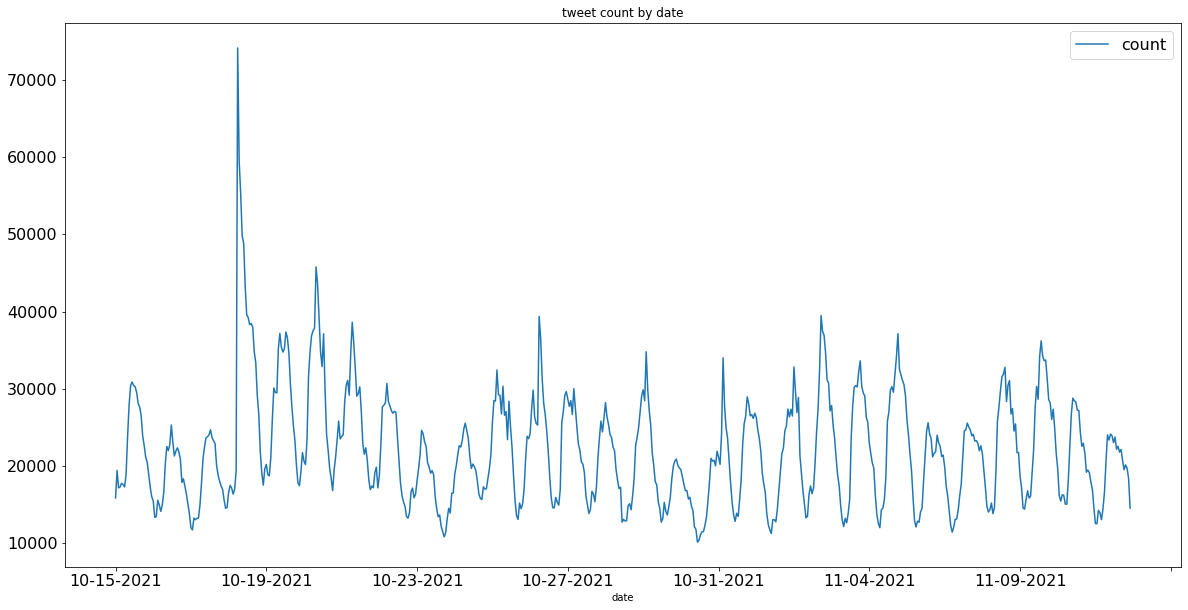

In [100]:
p_df_timeline.plot.line(x="date", y="count", title = "tweet count by date", figsize=(20,10), fontsize=16).legend(prop={'size': 16})



In [66]:
df_hour = df_user_time.groupBy('hour').agg(count('*').alias('count')).orderBy('hour', ascending = True)





In [67]:
df_hour.show(5)

+----+------+
|hour| count|
+----+------+
|   0|622187|
|   1|578730|
|   2|540832|
|   3|491579|
|   4|448839|
+----+------+
only showing top 5 rows



In [68]:
p_df_hour = df_hour.limit(10000).toPandas()

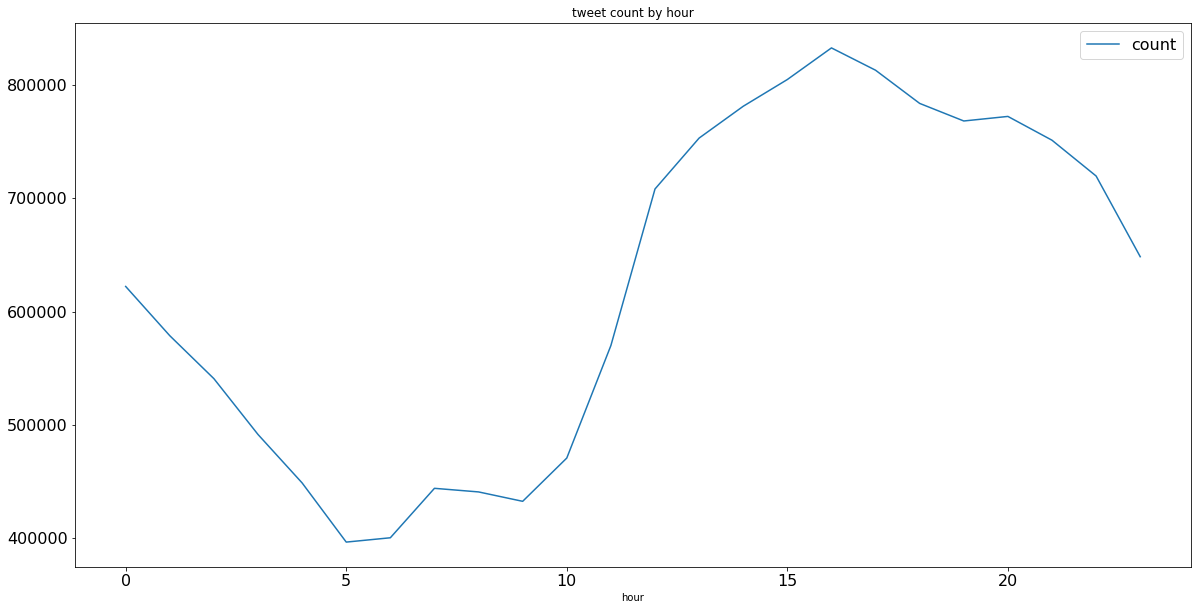

In [101]:
p_df_hour.plot.line(x="hour", y="count", title = "tweet count by hour", figsize=(20,10), fontsize=16).legend(prop={'size': 16})


In [72]:
df_weekday = df_user_time.groupBy('weekday', 'hour').agg(count('*').alias('count')).orderBy('weekday', 'hour', ascending = True)


In [73]:
df_weekday.show(5)

+-------+----+-----+
|weekday|hour|count|
+-------+----+-----+
|    Fri|   0|80860|
|    Fri|   1|80012|
|    Fri|   2|77474|
|    Fri|   3|81494|
|    Fri|   4|77830|
+-------+----+-----+
only showing top 5 rows



In [ ]:
p_df_timeline = df_timeline.limit(10000).toPandas()

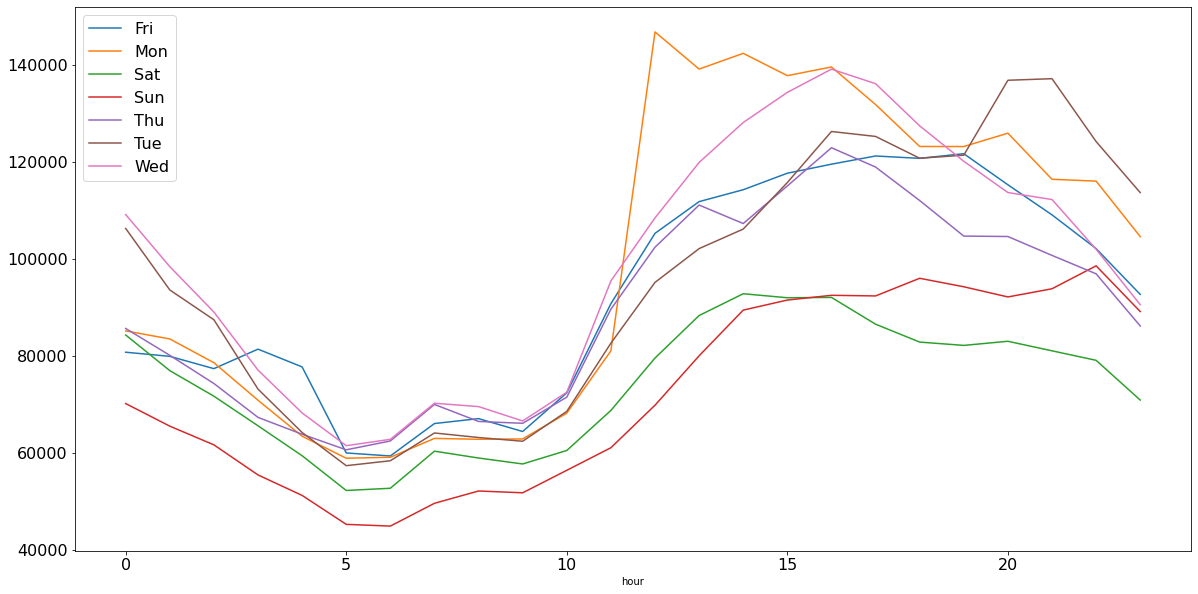

In [99]:
p_df_weekday.pivot_table(index = 'hour', columns = 'weekday', values = 'count', aggfunc = 'sum').plot.line(figsize = (20, 10), fontsize=16).legend(prop={'size': 16})


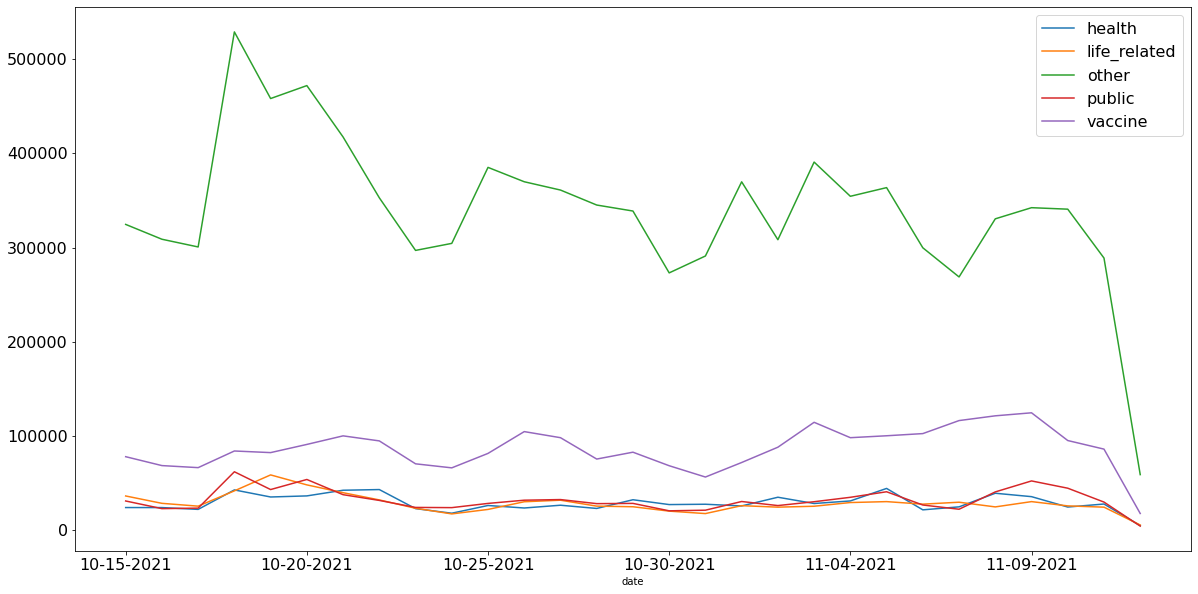

In [96]:
p_df_timeline.pivot_table(index = 'date', columns = 'text_theme', values = 'count', aggfunc = 'sum').plot.line(figsize = (20, 10), fontsize=16).legend(prop={'size': 16})


In [75]:
p_df_weekday = df_weekday.limit(10000).toPandas()

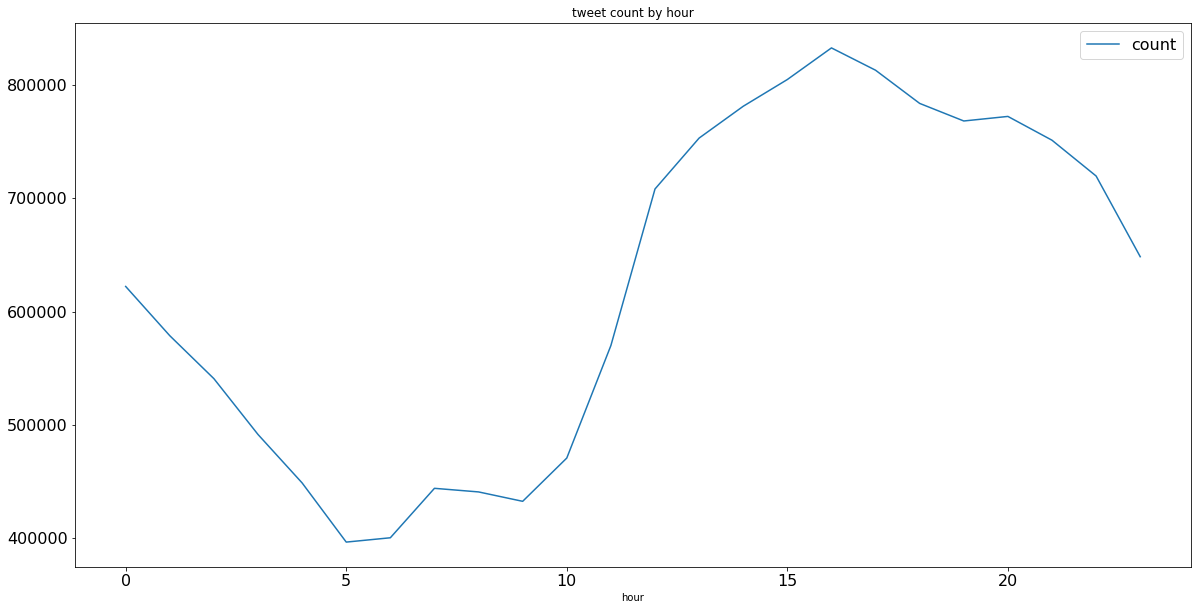

In [95]:
p_df_hour.plot.line(x="hour", y="count", title = "tweet count by hour", figsize=(20,10), fontsize=16).legend(prop={'size': 16})


In [97]:
df_timeline = df_user_time.groupBy('organization', 'date').agg(count('*').alias('count')).orderBy('date', ascending = True)

In [98]:
p_df_org = df_timeline.limit(10000).toPandas()

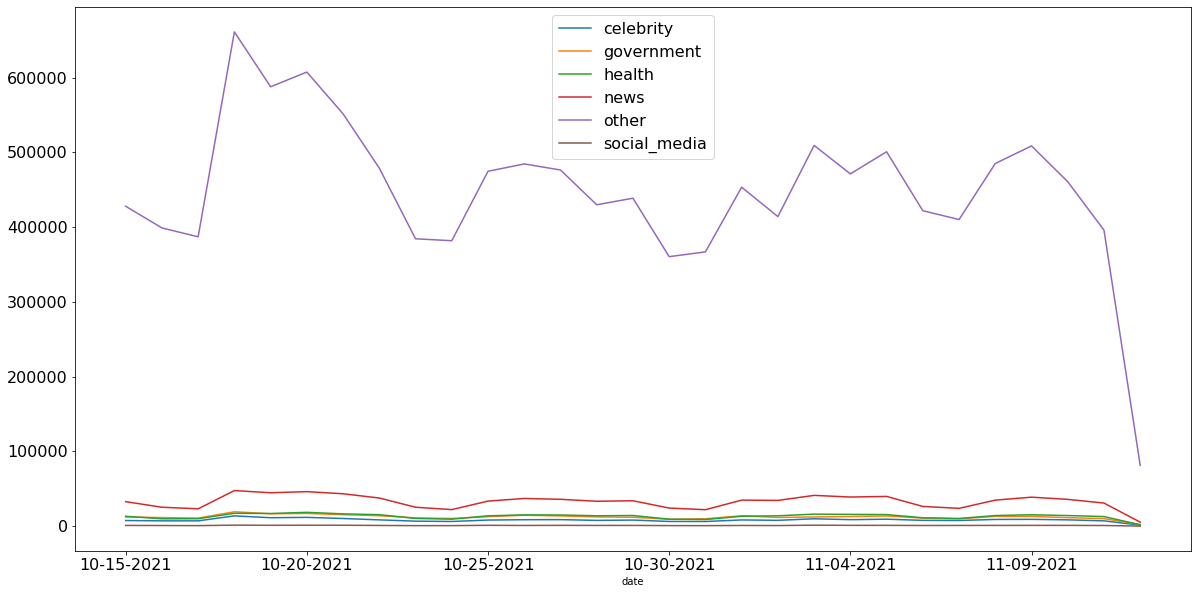

In [99]:
p_df_org.pivot_table(index = 'date', columns = 'organization', values = 'count', aggfunc = 'sum').plot.line(figsize = (20, 10), fontsize=16).legend(prop={'size': 16})


In [83]:
p_df_day = df_day.limit(10000).toPandas()

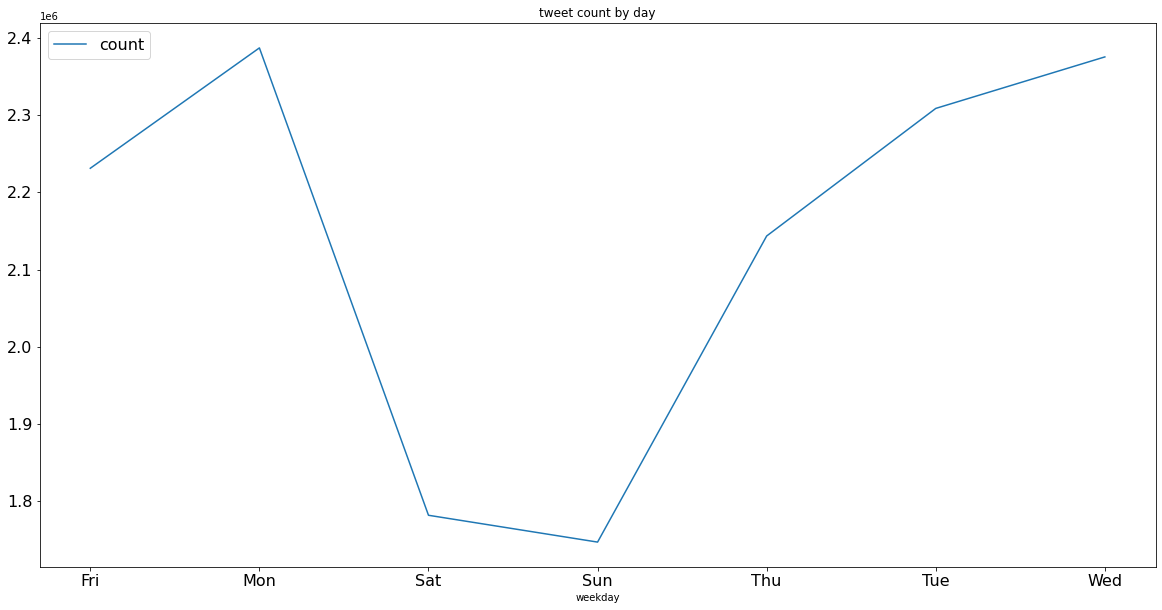

In [92]:

p_df_day.plot.line(x="weekday", y="count", title = "tweet count by day", figsize=(20,10), fontsize=16).legend(prop={'size': 16})


In [ ]:
df_geo_id.write.format("com.databricks.spark.csv").\
option("header", "true").\
mode('overwrite').\
save('gs://' + bucket_write + '/df_geo_id')

In [293]:
df_time = df_text_covid.select('user', 'created_at').\
withColumn('time',from_unixtime('created_at').cast(DateType()))

In [294]:
df_time_sep = df_time.\
withColumn('year', year('time')).\
withColumn('month', month('time'))

In [296]:
df_time_sep_group = df_time_sep.groupBy('year', 'month').agg(count('*').alias('count')).orderBy('year', 'month')

In [ ]:
df_time_sep_group.show(5)

In [ ]:
time.withColumn("date",from_unixtime('timestamp').cast(DateType()))